In [1]:
# changing the working directory and loading the env variables
import os
from dotenv import load_dotenv

os.chdir(os.path.join(os.getcwd(),os.pardir))
load_dotenv()

True

In [2]:
# setting up langsmith tracing
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'flipkart-scraping'

In [3]:
from typing import Sequence, Optional, TypedDict, Annotated, Union, Literal, Callable
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage, HumanMessage, AIMessage
from playwright.async_api import Page
import operator
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, PromptTemplate, MessagesPlaceholder
from langchain_core.prompts.image import ImagePromptTemplate
from langgraph.graph import StateGraph, END
from langchain_core.runnables import Runnable, RunnableConfig

class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str

class Prediction(TypedDict):
    action: str
    args: Optional[Sequence[str]]

class AgentState(TypedDict):
    page: Page
    input: str
    img: str
    bboxes: Sequence[BBox]
    prediction: Prediction
    scratchpad: Annotated[Sequence[BaseMessage],operator.add]
    bbox_descriptions: Sequence[str]
    tool_output: str

In [4]:
import asyncio
import platform
from langchain_core.pydantic_v1 import BaseModel, Field

async def click(bbox_id:int, bboxes:Sequence[BBox], page: Page)->str:
    """Used to click on a bounding box on a web page.

    Args:
        page (Page): The page to click on.
        bbox_id (int): The ID of the bounding box to click on.
        bboxes (Sequence[BBox]): The list of bounding boxes on the page.

    Returns:
        str: The message that the click was successful.
    """
    try:
        bbox = bboxes[bbox_id]
    except Exception as e:
        return f"Error occured. {e}"
    x, y = bbox["x"], bbox["y"]
    _ = await page.mouse.click(x, y)
    return {"tool_output": f"Clicked {bbox_id}"}


async def type_text(page: Page, bbox_id:int, type_content:str, bboxes:Sequence[BBox])->str:
    """Used to type text in a web page.

    Args:
        page (Page): The page to type on.
        bbox_id (int): The ID of the bounding box to type on.
        type_content (str): The content to type.
        bboxes (Sequence[BBox]): The list of bounding boxes on the page.

    Returns:
        str: The message that the text was typed successfully.
    """
    bbox = bboxes[bbox_id]
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(type_content)
    await page.keyboard.press("Enter")
    return {"tool_output": f"Typed {type_content} and submitted"}

# Union[Literal['WINDOW'],int]
async def scroll(page: Page, target: str, direction:Literal['up','down'], bboxes: Sequence[BBox])->str:
    """Used to scroll up or down in a web page.
    If the complete window needs to be scrolled, then the target is 'WINDOW'. Else the target is the ID of the bounding box to scroll in.

    Args:
        page (Page): The page to scroll in.
        target str: The target to scroll in. 'WINDOW' if the complete window needs to be scrolled, else the ID of the bounding box to scroll in.
        direction (Literal['up','down']): The direction to scroll in.
        bboxes (Sequence[BBox]): The list of bounding boxes on the page.

    Returns:
        str: The message that the scroll was successful.
    """
    if target == "WINDOW":
        scroll_amount = 600
        scroll_direction = (
            -scroll_amount if direction == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        scroll_amount = 200
        target_id = int(target)
        bbox = bboxes[target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return {"tool_output": f"Scrolled {direction} in {'WINDOW' if target == 'WINDOW' else 'element'} with ID {target}."}


async def wait()->str:
    """Used to wait for 5 seconds. This is generally used to wait for the page to load.

    Returns:
        str: The message that the wait is complete.
    """
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return {"tool_output": f"Waited for {sleep_time}s."}


async def go_back(page: Page)->str:
    """Used to navigate back a page.

    Args:
        page (Page): The page to navigate back in.

    Returns:
        str: The message that the navigation is complete.
    """
    await page.go_back()
    return {"tool_output": f"Navigated back a page to {page.url}."}


async def to_google(page: Page)->str:
    """Used to navigate to google.com.

    Args:
        page (Page): The page to navigate to google.com in.

    Returns:
        str: The message that the navigation is complete.
    """
    await page.goto("https://www.google.com/")
    return {"tool_output": "Navigated to google.com."}

functions_list = [click, type_text, scroll, wait, go_back, to_google]

class CompleteTask(BaseModel):
    """Call this when the given task is completed."""
    answer: str = Field("The answer when the task is complete. 'COMPLETED' when the task is a navigation task, else it will be the content of the answer which the user requested for.")

class Order(TypedDict):
    """The structure of an order"""
    product_name: str = Field(description="The name of the product")
    product_price: int = Field(description="The price of the product")
    delivery_status: Literal[0,1,2,3] = Field(description="Delivery status of the product. If delivered, then 1. If not delivered, then 0. If the product is refunded, then 2. If cancelled, then 3.")

class OutputOrders(BaseModel):
    """Call this to save the extracted orders in a structured format. This will be used to save the orders in the database. MUST BE CALLED BEFORE CALLING CompleteTask."""
    orders: Sequence[Order] = Field(description="The list of orders")

In [5]:
# helper functions
from langchain_core.runnables import RunnableLambda, chain, RunnablePassthrough
import base64
import asyncio

with open("src/scripts/mark_page.js") as f:
    mark_page_script = f.read()

@chain
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except:
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

In [6]:
from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatOllama
import functools

@chain
async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


@chain
def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel","")
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type","")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "Valid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


with open('src/prompts/system_prompt.txt','r') as f:
    system_prompt = f.read()


prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    HumanMessagePromptTemplate.from_template('{input}'),
    MessagesPlaceholder(variable_name='scratchpad', optional=True),
    HumanMessagePromptTemplate(prompt=[
        ImagePromptTemplate(input_variables=['img'], template={'url': 'data:image/png;base64,{img}'}),
        PromptTemplate(input_variables=['bbox_descriptions'], template='{bbox_descriptions}'),
    ])
])

# llm = ChatOllama(model="llava:7b")
llm = ChatOpenAI(model="gpt-4o", max_tokens=4096).bind_functions(functions_list+[CompleteTask,OutputOrders])
# agent = annotate | RunnablePassthrough.assign(
#     prediction = format_descriptions | prompt | llm.bind_functions(functions_list+[CompleteTask])
# )


def create_agent_with_prompt(runnable:Runnable)->Callable:
    @chain
    async def func(state:AgentState)->AgentState:
        result = await runnable.ainvoke(state)
        if not result.tool_calls and (
            not result.content
            or isinstance(result.content,list)
            and not result.content[0].get('text')
        ):
            messages = [AIMessage(content="Seems like my last response did not have any tool calls or content. I need to check my response", additional_kwargs={})]
            return {**state, 'scratchpad': messages}
        
        else:
            return {**state, 'scratchpad': [result]}
    return func

agent = create_agent_with_prompt(runnable = prompt|llm)

agent_chain = annotate | format_descriptions | agent

In [7]:
@chain
def update_scratchpad(state: AgentState):
    """Update the scratchpad with the latest message."""
    message = state.get('scratchpad')[-1]
    tool_output = state.get('tool_output')
    if message.additional_kwargs:
        # tool_call_id = message.id
        return_message = SystemMessage(content=tool_output) #tool_call_id=tool_call_id
    else:
        return_message = HumanMessage(content="No tool was called in your last action. Please recheck your last action.")
    return {**state, "scratchpad": [return_message]}


def agent_router(state: AgentState):
    """Routing function for the agent"""
    message = state.get('scratchpad')[-1]
    if message.additional_kwargs:
        function_name = message.additional_kwargs['function_call']['name']
        if function_name == OutputOrders.__name__:
            return 'structure_orders'
        elif function_name == CompleteTask.__name__:
            return '__end__'
        else:
            return function_name
    else:
        return '__end__'

In [8]:
# import json

# class Assistant:
#     def __init__(self, runnable: Runnable):
#         self.runnable = runnable
    
#     async def __call__(self, state: AgentState, config: RunnableConfig):
#         message = await self.runnable.ainvoke(state)
#         if not message.tool_calls and (
#             not message.content
#             or isinstance(message.content,list)
#             and not message.content[0].get('text')
#         ):
#             messages = [('user','Respond with a real output or correct tool call')]
#             return {**state, 'scratchpad': messages}
        
#         else:
#             return {**state, 'scratchpad': [message]}

In [9]:
@chain
async def type_text_node(state: AgentState):
    message = state['scratchpad'][-1]
    ai_kwargs = eval(message.additional_kwargs['function_call']['arguments'])
    state_kwargs = {
        'page': state['page'],
        'bboxes': state['bboxes']
    }
    result = await type_text(**ai_kwargs, **state_kwargs)
    return result

@chain
async def click_node(state: AgentState):
    message = state['scratchpad'][-1]
    ai_kwargs = eval(message.additional_kwargs['function_call']['arguments'])
    state_kwargs = {
        'page': state['page'],
        'bboxes': state['bboxes']
    }
    result = await click(**ai_kwargs, **state_kwargs)
    return result

@chain
async def scroll_node(state: AgentState):
    message = state['scratchpad'][-1]
    ai_kwargs = eval(message.additional_kwargs['function_call']['arguments'])
    state_kwargs = {
        'page': state['page'],
        'bboxes': state['bboxes']
    }
    result = await scroll(**ai_kwargs, **state_kwargs)
    return result

@chain
async def go_back_node(state: AgentState):
    result = await go_back(state['page'])
    return result

@chain
async def to_google_node(state: AgentState):
    result = await to_google(state['page'])
    return result

@chain
async def structure_orders(state: AgentState):
    message = state.get('scratchpad')[-1]
    orders = eval(message.additional_kwargs['function_call']['arguments'])
    with open('orders.json','w') as f:
        json.dump(orders,f)
    return {'tool_output': 'Orders saved successfully'}

In [10]:
# building the graph

builder = StateGraph(AgentState)


builder.add_node('agent', agent_chain)
builder.set_entry_point('agent')


builder.add_node('update_scratchpad', update_scratchpad)
builder.add_edge('update_scratchpad', 'agent')


tools_dict = {
    'click':click_node,
    'type_text':type_text_node,
    'scroll':scroll_node,
    'wait':wait,
    'go_back':go_back_node,
    'to_google':to_google_node,
    'structure_orders': structure_orders,
}


for node_name, tool in tools_dict.items():
    builder.add_node(node_name, tool)
    builder.add_edge(node_name, 'update_scratchpad')


builder.add_conditional_edges(
    'agent',
    agent_router,
    {
        '__end__': END,
        'CompleteTask': END,
        'structure_orders':'structure_orders',
        'click':'click',
        'type_text':'type_text',
        'scroll':'scroll',
        'wait':'wait',
        'go_back':'go_back',
        'to_google':'to_google',
    }
)

graph = builder.compile()

In [11]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")

async def call_agent(question:str, page:Page, max_steps:int=7):
    event_stream = graph.astream(
        input = {
            'page':page,
            'input':question,
            'scratchpad':[],
        },
        config={
            'recursion_limit':max_steps
        }
    )

    steps = []
    async for event in event_stream:
        # display.clear_output(wait=False)
        print("="*30)
        if "agent" not in event:
            continue
        message = event['agent']['scratchpad'][-1]
        print(message.content)
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        # print(f"AGENT: {content}")
        # print(addition_kwargs)

    # final_answer = None
    # steps = []
    # async for event in event_stream:
    #     # We'll display an event stream here
    #     if "agent" not in event:
    #         continue
    #     pred = event["agent"].get("prediction") or {}
    #     action = pred.get("action")
    #     action_input = pred.get("args")
    #     display.clear_output(wait=False)
    #     steps.append(f"{len(steps) + 1}. {action}: {action_input}")
    #     print("\n".join(steps))
    #     display.display(display.Image(base64.b64decode(event["agent"]["img"])))
    #     if "ANSWER" in action:
    #         final_answer = action_input[0]
    #         break
    # # page.close()
    # # browser.close()
    # return final_answer

Category: Extraction
Thought: I need to search for the Flipkart website using the search box.
Action: Type in the search box with the query "Flipkart".




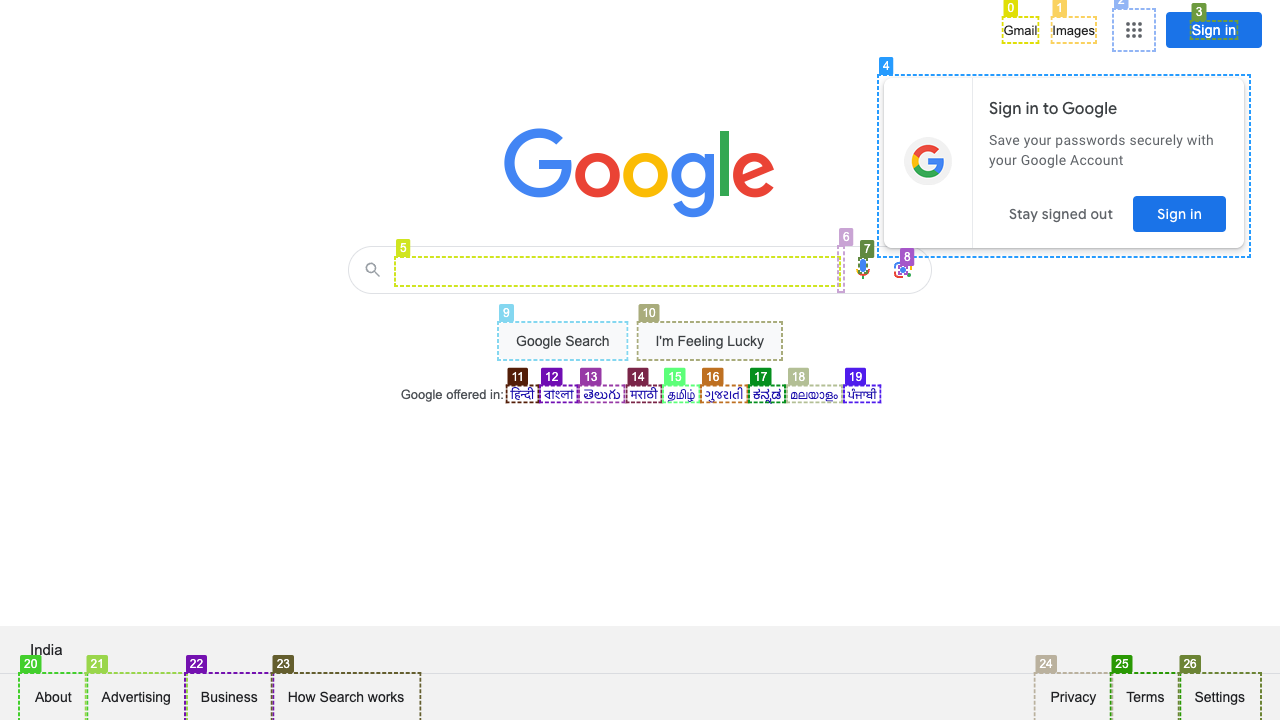

Category: Navigation
Thought: I need to navigate to the Flipkart website by clicking on the relevant link.
Action: Click on the link with the text "Flipkart" and URL "https://www.flipkart.com".




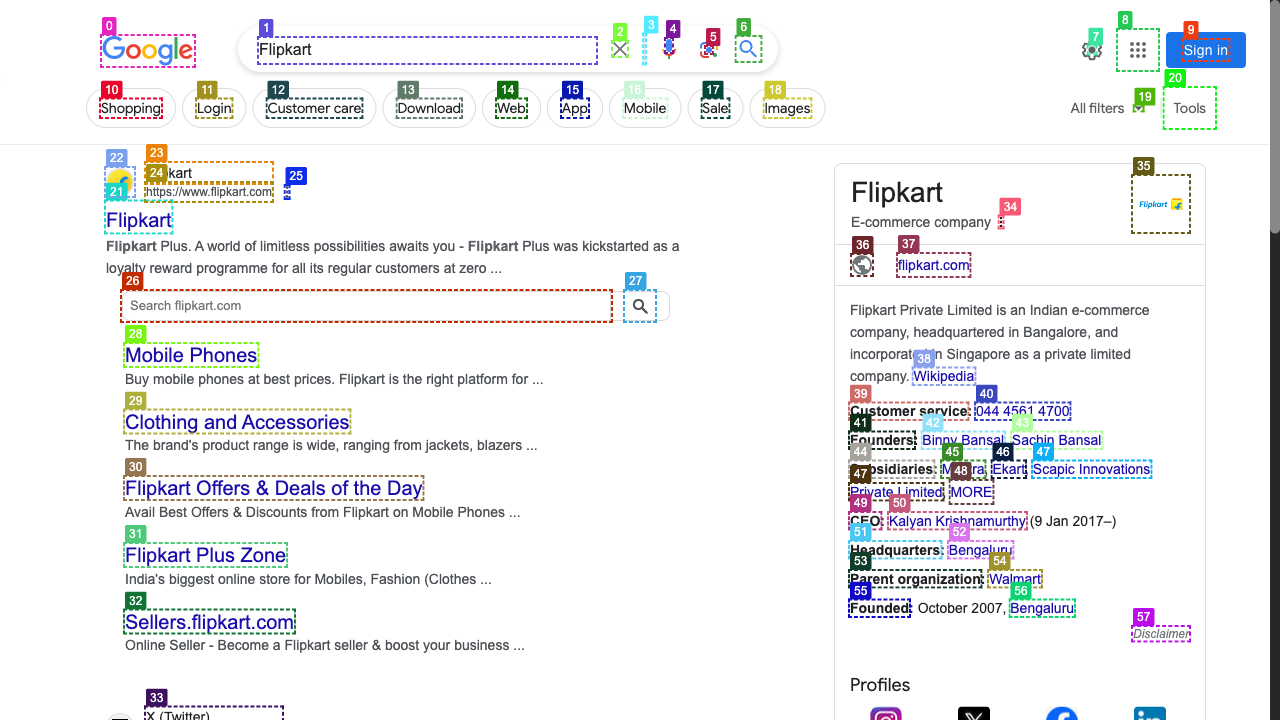

In [12]:
res = await call_agent("Navigate to flipkart website and stop", page, max_steps = 100)

In [109]:
with open('user_prompt.txt', 'r') as f:
    user_input = f.read()

res = await call_agent(user_input, page, max_steps = 100)

content='Category: Extraction\nThought: The page contains multiple orders with their respective details. I need to extract the details of each order and scroll down to ensure all orders are captured.\nAction: Extract the details of the current visible orders.\n\nDetails extracted so far:\n1. **Product Name**: Terabyte 802 Wi-Fi Receiver 2.4Ghz 802.11\n   **Price**: ₹240\n   **Delivery Status**: Delivered on May 25, 2019\n\n2. **Product Name**: Cover Alive Back Cover for Mi A1\n   **Price**: ₹221\n   **Delivery Status**: Cancelled on May 16, 2019\n\n3. **Product Name**: boAt Stone 1000 14 W Portable Bluetooth Speaker\n   **Price**: ₹2,499\n   **Delivery Status**: Delivered on May 22, 2019\n\n4. **Product Name**: Adpo ASGC-A120 Screen Guard for Micromax\n   **Price**: ₹99\n   **Delivery Status**: Delivered on Oct 20, 2015\n\n5. **Product Name**: Adpo ASGC-XPE4 Screen Guard for Sony Xperia\n   **Price**: ₹99\n   **Delivery Status**: Delivered on Oct 20, 2015\n\nNow, I will scroll down to 

In [23]:
# user_input = "What is the price of iphone 15 on flipkart?"
# res = await call_agent(user_input, page)

In [14]:
await page.close()
await browser.close()

In [24]:
content = await page.content()

In [31]:
import requests
from bs4 import BeautifulSoup

content = requests.get(page.url)

In [64]:
soup = BeautifulSoup(content.text, "html.parser")
temp = soup.find('div', {'class': '._4teGKY'})

In [65]:
type(temp)

NoneType

In [54]:
# elements = page.locator('//*[@id="container"]/div/div[3]/div[2]/div/div[3]/div[2]/div[2]/div/a[1]/div[1]/div[1]/div/div[2]/div/span')
# ._4teGKY

elements = page.locator('.row bTeFUC kn1h+D')
# //*[@id="container"]/div/div[3]/div[2]/div/div[3]/div[2]/div[2]/div/a[2]/div/div[1]/div/div[2]/div/span
# await elements.text_content()
await elements.all_text_contents()

[]

In [35]:
temp

In [36]:
soup

<!DOCTYPE html>
<html lang="en"><head><link href="https://rukminim2.flixcart.com" rel="preconnect"/><link href="//static-assets-web.flixcart.com/fk-p-linchpin-web/fk-cp-zion/css/app_modules.chunk.c48a12.css" rel="stylesheet"/><link href="//static-assets-web.flixcart.com/fk-p-linchpin-web/fk-cp-zion/css/app.chunk.0d82ef.css" rel="stylesheet"/><meta content="text/html; charset=utf-8" http-equiv="Content-type"/><meta content="IE=Edge" http-equiv="X-UA-Compatible"/><meta content="102988293558" property="fb:page_id"/><meta content="658873552,624500995,100000233612389" property="fb:admins"/><link href="https:///www/promos/new/20150528-140547-favicon-retina.ico" rel="shortcut icon"/><link href="/osdd.xml?v=2" rel="search" type="application/opensearchdescription+xml"/><meta content="website" property="og:type"/><meta content="Flipkart.com" name="og_site_name" property="og:site_name"/><link href="/apple-touch-icon-57x57.png" rel="apple-touch-icon" sizes="57x57"/><link href="/apple-touch-icon-72

# Experiments

In [117]:
await page.fill('xpath=//*[@id="container"]/div/div[3]/div/div[2]/div/form/div[1]/input','9479723522')
await page.click('xpath=//*[@id="container"]/div/div[3]/div/div[2]/div/form/div[3]/button')

# element = await page.wait_for_selector('//*[@id="qEntmMbNCtbBXuk"]')
# await element.scroll_into_view(center=True)
# await element.click()
# await page.mouse.down(timeout=3000)
# await page.mouse.up

TimeoutError: Page.click: Timeout 30000ms exceeded.
Call log:
waiting for locator("//*[@id=\"qEntmMbNCtbBXuk\"]")


In [127]:
await page.click('p#VWbKIGTWGAniBZN', delay=12*1000)

TimeoutError: Page.click: Timeout 30000ms exceeded.
Call log:
waiting for locator("p#VWbKIGTWGAniBZN")


CancelledError: 

In [15]:
# from langchain_openai import ChatOpenAI
# from langchain_core.prompts import ChatPromptTemplate

# def add_two_numbers(a:int, b:int)->int:
#     """Use this to add two numbers"""
#     return a+b

# all_functions = [add_two_numbers]

# prompt = ChatPromptTemplate.from_messages([
#     ('system','You are a helpful assistant. Please help the user with their query. You are not very good with maths. So if you encounter a match problem, remember to call a tool'),
#     ('user','{input}')
# ])

# llm = ChatOpenAI(model='gpt-3.5-turbo')

# agent = prompt | llm.bind_functions(all_functions)

In [16]:
# prompt.format_messages(input='What is 2+2?')

In [17]:
# result = agent.invoke({'input':'What is 2+5? Use a tool to calculate this.'})

In [18]:
# result

In [19]:
# result.additional_kwargs

In [20]:
# if {1:1}:
#     print('hello')

In [21]:
# type(result)

In [22]:
# from langchain_core.messages import AIMessage
# message = AIMessage(content="", additional_kwargs={
#         "tool_calls": [
#             {
#                 "id": "call_oRSmfiNKrJBfCCBP7y0uglry",
#                 "function": {
#                     "arguments": {"objective":"Create a SQL agent who is an expert in writing SQL queries. The agent should be able to capture the context of the problem, ask clarifying questions, and generate SQL queries.","variables":[],"constraints":["Output should not be plain text"],"requirements":["Output must be a SQL query"]},
#                     "name": "PromptInstructions"
#                 },
#                 "type": "function"
#             }
#         ]
#     }, response_metadata={
#         "token_usage": {
#             "completion_tokens": 70,
#             "prompt_tokens": 436,
#             "total_tokens": 506
#         },
#         "model_name": "gpt-3.5-turbo",
#         "system_fingerprint": None,
#         "finish_reason": "tool_calls",
#         "logprobs": None
#     }, id="run-4c15f1fe-6142-4fbc-810f-079e61314ebd-0", tool_calls=[
#         {
#             "name": "PromptInstructions",
#             "args": {
#                 "objective": "Create a SQL agent who is an expert in writing SQL queries. The agent should be able to capture the context of the problem, ask clarifying questions, and generate SQL queries.",
#                 "variables": [],
#                 "constraints": [
#                     "Output should not be plain text"
#                 ],
#                 "requirements": [
#                     "Output must be a SQL query"
#                 ]
#             },
#             "id": "call_oRSmfiNKrJBfCCBP7y0uglry"
#         }
#     ])

In [23]:
# message.tool_calls

In [24]:
# message.additional_kwargs['tool_calls']